In [34]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from itertools import product
import numpy as np

from tqdm import tqdm
from sklearn.svm import SVC

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms

In [3]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

sys.path.append(parent_dir)

from utils import AddGaussianNoise, AddImpulseNoise

# MNIST Dataset

## Data Loading

In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

full_data = torch.cat([train_dataset.data, test_dataset.data], dim=0)
full_targets = torch.cat([train_dataset.targets, test_dataset.targets], dim=0)

MNIST_data = full_data.view(len(full_data), -1).numpy().astype('float32') / 255.0

MNIST = {
    "data": MNIST_data,
    "target": full_targets.numpy()
}

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# SmallCNN

A SGD classifer is not enough to get reliable insights on CIFAR-10 dataset so we will use a lightweight CNN. This will allow us to accurately estimate the influence of training order

In [39]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Analysis

### (0) Base Case

#### Pre-analysis

In [43]:
# standardization
X_MNIST = StandardScaler().fit_transform(MNIST["data"])
y_MNIST = MNIST["target"]

# Split into train and test
X_train_MNIST, X_test_MNIST, y_train_MNIST, y_test_MNIST = train_test_split(X_MNIST, y_MNIST, test_size=0.2, shuffle=True, random_state=42)

#### Analysis

Let's try as the Vanilla Base Case: Train on the entire dataset using uniform random shuffling for each epoch.

In [53]:
# === Training Setup ===
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 5

# === Training Loop ===
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_loss:.4f}")

# === Evaluation ===
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Using device: mps
Epoch 1/5 - Train Loss: 0.1794
Epoch 2/5 - Train Loss: 0.0498
Epoch 3/5 - Train Loss: 0.0348
Epoch 4/5 - Train Loss: 0.0259
Epoch 5/5 - Train Loss: 0.0186
Test Accuracy: 0.9904


### (1) Curriculum Learning

#### Pre-analysis

As curriculum learning is based on giving samples in increasing difficulty level to the model, we first need to define a difficulty function. We will base ours on difference between the distance of each point to the centroid of each class.

In [7]:
def compute_MNIST_difficulty(X, y, centroids):
    dist = np.linalg.norm(X - centroids[y], axis=1)
    return dist

In [8]:
percentages = np.linspace(0.75, 1, 5)

#### Analysis

In [32]:
# Convert to numpy
X_train = train_dataset.data.numpy().astype('float32') / 255.0
y_train = train_dataset.targets.numpy()

# Flatten for difficulty calculation
X_train_flat = X_train.reshape(len(X_train), -1)

In [36]:
# Compute centroids
centroids = np.zeros((10, X_train_flat.shape[1]))
for i in range(10):
    centroids[i] = X_train_flat[y_train == i].mean(axis=0)

# Compute difficulty score
difficulties = compute_MNIST_difficulty(X_train_flat, y_train, centroids)

# Normalize difficulties to [0, 1]
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())

# Sort indices by difficulty
sorted_indices = np.argsort(difficulties)

# Define your CNN
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert to 3-channel tensors
X_train_tensor = torch.tensor(X_train).unsqueeze(1).repeat(1, 3, 1, 1)  # shape: (N, 3, 28, 28)
y_train_tensor = torch.tensor(y_train)

# Curriculum schedule (percent of training data to use at each phase)
phases = np.linspace(0.1, 1.0, 5)

for phase in phases:
    n_samples = int(phase * len(sorted_indices))
    selected_idx = sorted_indices[:n_samples]

    # Create dataloader with increasing difficulty
    train_subset = TensorDataset(X_train_tensor[selected_idx], y_train_tensor[selected_idx])
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

    print(f"Training with {n_samples} samples...")

    # Train for one epoch (or more if you prefer)
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


Training with 6000 samples...
Training with 19500 samples...
Training with 33000 samples...
Training with 46500 samples...
Training with 60000 samples...


In [37]:
# Prepare test set
X_test = test_dataset.data.numpy().astype('float32') / 255.0
X_test_tensor = torch.tensor(X_test).unsqueeze(1).repeat(1, 3, 1, 1)
y_test_tensor = torch.tensor(test_dataset.targets.numpy())
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Final test accuracy: {correct / total:.4f}")

Final test accuracy: 0.9879


### (2) Self-Paced Learning

In Self-Paced Learning, the model is supposed to:

• learn from easier samples first (based on current loss)

• adaptively expand its training set to include harder samples as it becomes more confident

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

In [40]:
classes = np.unique(y_train_MNIST)


# Prepare data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 28, 28)  # MNIST is 1 channel
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 28, 28)
y_test_tensor = torch.tensor(test_dataset.targets.numpy())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss(reduction='none')  # Per-sample loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Self-Paced Learning parameters
# lambda t : init threshold corresponding to the maximum loss (which then determines difficulty)
# lambda growth : incrementation at every step
# the model is then able to decide how many samples of such difficilty it can handle
lambda_threshold = 0.5
lambda_step = 0.3
max_lambda = 10.0
epochs_per_step = 1

X_train_all = X_train_tensor.to(device)
y_train_all = y_train_tensor.to(device)

for step in range(20):  # Enough steps to reach max_lambda
    model.eval()
    with torch.no_grad():
        outputs = model(X_train_all)
        losses = criterion(outputs, y_train_all)  # shape: (N,)
        selected_indices = (losses < lambda_threshold).nonzero(as_tuple=True)[0]

    if len(selected_indices) == 0:
        print("No samples selected at threshold", lambda_threshold)
        lambda_threshold += lambda_step
        continue

    # Training only on selected samples
    selected_X = X_train_all[selected_indices]
    selected_y = y_train_all[selected_indices]

    dataset = TensorDataset(selected_X.cpu(), selected_y.cpu())
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    model.train()
    for epoch in range(epochs_per_step):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

    print(f"Step {step+1}: λ = {lambda_threshold:.2f}, using {len(selected_indices)} samples")

    lambda_threshold += lambda_step
    if lambda_threshold > max_lambda:
        break

# Final evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.to(device))
    test_preds = test_outputs.argmax(dim=1)
    accuracy = (test_preds == y_test_tensor.to(device)).float().mean().item()
    print(f"\nTest accuracy after SPL: {accuracy:.4f}")

No samples selected at threshold 0.5
No samples selected at threshold 0.8
No samples selected at threshold 1.1
No samples selected at threshold 1.4000000000000001
No samples selected at threshold 1.7000000000000002
No samples selected at threshold 2.0
Step 7: λ = 2.30, using 24377 samples
Step 8: λ = 2.60, using 60000 samples
Step 9: λ = 2.90, using 60000 samples
Step 10: λ = 3.20, using 37536 samples
Step 11: λ = 3.50, using 38004 samples
Step 12: λ = 3.80, using 60000 samples
Step 13: λ = 4.10, using 60000 samples
Step 14: λ = 4.40, using 48752 samples
Step 15: λ = 4.70, using 49912 samples
Step 16: λ = 5.00, using 60000 samples
Step 17: λ = 5.30, using 60000 samples
Step 18: λ = 5.60, using 50009 samples
Step 19: λ = 5.90, using 50108 samples
Step 20: λ = 6.20, using 60000 samples

Test accuracy after SPL: 0.9918


### (3) Hard-Example Mining

Hard-Example Mining consists in feeding the model only hard examples. In our case, we will consider that a sample is difficult if its normalized difficulty is greater or equal than 0,75 (in other words the top 25%).

In [50]:
# Normalize difficulty scores to [0, 1]
difficulty_scores = compute_MNIST_difficulty(X_train_flat, y_train, centroids)
difficulty_scores = (difficulty_scores - difficulty_scores.min()) / (difficulty_scores.max() - difficulty_scores.min())

# Select top 25% hardest samples (difficulty >= 0.75)
hard_mask = difficulty_scores >= 0.75
X_hard = X_train_tensor[hard_mask]
y_hard = y_train_tensor[hard_mask]

print(f"Selected {len(X_hard)} hard examples out of {len(X_train_flat)}")

# Create DataLoader for hard examples
batch_size = 64
hard_dataset = TensorDataset(X_hard, y_hard)
hard_loader = DataLoader(hard_dataset, batch_size=batch_size, shuffle=True)

# Define model (make sure in_channels=1)
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in hard_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(hard_dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(hard_dataset):.4f}, Accuracy: {acc:.4f}")

Selected 337 hard examples out of 60000
Epoch 1/5, Loss: 2.2376, Accuracy: 0.1662
Epoch 2/5, Loss: 2.0895, Accuracy: 0.3828
Epoch 3/5, Loss: 1.8972, Accuracy: 0.4065
Epoch 4/5, Loss: 1.6106, Accuracy: 0.4926
Epoch 5/5, Loss: 1.3202, Accuracy: 0.6083


### (4) Reverse Curriculum Learning

We are implementing **Reverse Curriculum Learning (RCL)** where the model starts learning from easier goals that are close to the target and gradually works backwards to more challenging starting states.

In [51]:
# Step 1: Compute normalized difficulty scores
difficulty_scores = compute_MNIST_difficulty(X_train_flat, y_train, centroids)
difficulty_scores = (difficulty_scores - difficulty_scores.min()) / (difficulty_scores.max() - difficulty_scores.min())

# Step 2: Sort samples by difficulty (descending)
sorted_indices = torch.argsort(torch.tensor(difficulty_scores), descending=True)
X_sorted = X_train_tensor[sorted_indices]
y_sorted = y_train_tensor[sorted_indices]

# Step 3: Reverse curriculum training
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
batch_size = 64
min_fraction = 0.25  # Start with top 25%
max_fraction = 1.0   # End with all examples

for epoch in range(epochs):
    # Compute current fraction of data to use
    frac = min_fraction + (max_fraction - min_fraction) * (epoch / (epochs - 1))
    n_samples = int(len(X_sorted) * frac)

    # Select subset of data
    X_subset = X_sorted[:n_samples]
    y_subset = y_sorted[:n_samples]

    # Create DataLoader
    subset_dataset = TensorDataset(X_subset, y_subset)
    subset_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

    # Training on current subset
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in subset_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / n_samples
    print(f"Epoch {epoch+1}/{epochs}, Samples: {n_samples}, Loss: {total_loss/n_samples:.4f}, Accuracy: {acc:.4f}")


Epoch 1/5, Samples: 15000, Loss: 0.6017, Accuracy: 0.8060
Epoch 2/5, Samples: 26250, Loss: 0.1334, Accuracy: 0.9590
Epoch 3/5, Samples: 37500, Loss: 0.0728, Accuracy: 0.9776
Epoch 4/5, Samples: 48750, Loss: 0.0451, Accuracy: 0.9860
Epoch 5/5, Samples: 60000, Loss: 0.0306, Accuracy: 0.9903


### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [52]:
# Step 1: Normalize difficulty scores
difficulty_scores = compute_MNIST_difficulty(X_train_flat, y_train, centroids)
difficulty_scores = (difficulty_scores - difficulty_scores.min()) / (difficulty_scores.max() - difficulty_scores.min())

# Step 2: Define strata (easy = 0-0.33, medium = 0.33-0.66, hard = 0.66-1.0)
easy_mask = (difficulty_scores < 0.33)
medium_mask = (difficulty_scores >= 0.33) & (difficulty_scores < 0.66)
hard_mask = (difficulty_scores >= 0.66)

X_easy, y_easy = X_train_tensor[easy_mask], y_train_tensor[easy_mask]
X_medium, y_medium = X_train_tensor[medium_mask], y_train_tensor[medium_mask]
X_hard, y_hard = X_train_tensor[hard_mask], y_train_tensor[hard_mask]

# Step 3: Model, criterion, optimizer
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 4: Training loop with stratified sampling
batch_size = 64
samples_per_stratum = 2000  # can adjust based on data size
epochs = 5

for epoch in range(epochs):
    # Stratified random sample from each difficulty bin
    indices_easy = torch.randperm(len(X_easy))[:samples_per_stratum]
    indices_medium = torch.randperm(len(X_medium))[:samples_per_stratum]
    indices_hard = torch.randperm(len(X_hard))[:samples_per_stratum]

    X_sample = torch.cat([X_easy[indices_easy], X_medium[indices_medium], X_hard[indices_hard]])
    y_sample = torch.cat([y_easy[indices_easy], y_medium[indices_medium], y_hard[indices_hard]])

    # Create DataLoader
    sampled_dataset = TensorDataset(X_sample, y_sample)
    loader = DataLoader(sampled_dataset, batch_size=batch_size, shuffle=True)

    # Training on sampled data
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(sampled_dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(sampled_dataset):.4f}, Accuracy: {acc:.4f}")

Epoch 1/5, Loss: 0.9636, Accuracy: 0.6957
Epoch 2/5, Loss: 0.2991, Accuracy: 0.9103
Epoch 3/5, Loss: 0.1975, Accuracy: 0.9429
Epoch 4/5, Loss: 0.1354, Accuracy: 0.9575
Epoch 5/5, Loss: 0.1003, Accuracy: 0.9690


# MNIST Dataset with Gaussian Noise

## Data Loading

We initialize a range of increasing difficulty. 
- 0.0: no noise — easiest samples
- 0.4: very noisy — hardest samples
- 0.5+ usually makes MNIST unreadable

In [62]:
# Load base MNIST (no transform)
base_train = datasets.MNIST(root='./data', train=True, download=True)
base_test = datasets.MNIST(root='./data', train=False, download=True)

full_data = torch.cat([base_train.data, base_test.data], dim=0).float() / 255.0
full_targets = torch.cat([base_train.targets, base_test.targets], dim=0)

# Expand with noise
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4]
augmented_data, augmented_targets, noise_labels = [], [], []

for level in noise_levels:
    noise = torch.randn_like(full_data) * level
    noisy_data = full_data + noise
    noisy_data = torch.clamp(noisy_data, 0.0, 1.0)

    augmented_data.append(noisy_data)
    augmented_targets.append(full_targets)
    noise_labels.append(torch.full_like(full_targets, level))

# Combine everything
augmented_data = torch.cat(augmented_data, dim=0).unsqueeze(1)  # (N*L, 1, 28, 28)
augmented_targets = torch.cat(augmented_targets, dim=0)
noise_labels = torch.cat(noise_labels, dim=0)

# Final dataset
augmented_dataset = TensorDataset(augmented_data, augmented_targets, noise_labels)

In [63]:
# Sizes of original MNIST splits
N_train = len(base_train)  # 60000
N_test = len(base_test)    # 10000

# Augmented data shape: [num_levels * (N_train + N_test), 1, 28, 28]
samples_per_level = N_train + N_test

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for i in range(len(noise_levels)):
    start = i * samples_per_level
    end = start + samples_per_level

    # Get this noise level's full data and split it
    X_level = augmented_data[start:end]
    y_level = augmented_targets[start:end]

    X_train_list.append(X_level[:N_train])
    y_train_list.append(y_level[:N_train])
    X_test_list.append(X_level[N_train:])
    y_test_list.append(y_level[N_train:])

# Final concatenated noisy train/test sets (mixed noise levels)
X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: torch.Size([300000, 1, 28, 28]), y_train: torch.Size([300000])
X_test: torch.Size([50000, 1, 28, 28]), y_test: torch.Size([50000])


In [64]:
noise_levels_train_list = []

for i, level in enumerate(noise_levels):
    # Number of training samples for this noise level
    num_train_samples = N_train
    
    # Create a tensor filled with the noise level index: 0, 1, 2, 3 or 4
    noise_level_tensor = torch.full((num_train_samples,), fill_value=i)
    
    noise_levels_train_list.append(noise_level_tensor)

# Concatenate to get noise_levels_train for the entire train set
noise_levels_train = torch.cat(noise_levels_train_list, dim=0)

print(f"noise_levels_train shape: {noise_levels_train.shape}")  # Should be (len(X_train),)


noise_levels_train shape: torch.Size([300000])


## Analysis

### (0) Base Case

#### Analysis

In [57]:
# DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # random sampling baseline
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f}, Train Acc: {train_acc:.4f}")

# Evaluate
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
test_acc = correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/5 - Train Loss: 0.0900, Train Acc: 0.9717
Epoch 2/5 - Train Loss: 0.0258, Train Acc: 0.9914
Epoch 3/5 - Train Loss: 0.0154, Train Acc: 0.9948
Epoch 4/5 - Train Loss: 0.0107, Train Acc: 0.9964
Epoch 5/5 - Train Loss: 0.0077, Train Acc: 0.9973
Test Accuracy: 0.9858


### (1) Curriculum Learning

#### (1.1) Cumulative Curriculum Learning

In [65]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels <= {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train <= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise levels <= 0
  Epoch 1/1 - Loss: 0.1732, Acc: 0.9480

Stage 2/5: Using noise levels <= 1
  Epoch 1/1 - Loss: 0.0422, Acc: 0.9870

Stage 3/5: Using noise levels <= 2
  Epoch 1/1 - Loss: 0.0243, Acc: 0.9921

Stage 4/5: Using noise levels <= 3
  Epoch 1/1 - Loss: 0.0177, Acc: 0.9941

Stage 5/5: Using noise levels <= 4
  Epoch 1/1 - Loss: 0.0188, Acc: 0.9937

Final Test Accuracy: 0.9860


#### (1.2) Strict Curriculum Learning

In [68]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise level 0
  Epoch 1/1 - Loss: 0.1667, Acc: 0.9497

Stage 2/5: Using noise level 1
  Epoch 1/1 - Loss: 0.0490, Acc: 0.9851

Stage 3/5: Using noise level 2
  Epoch 1/1 - Loss: 0.0402, Acc: 0.9875

Stage 4/5: Using noise level 3
  Epoch 1/1 - Loss: 0.0446, Acc: 0.9852

Stage 5/5: Using noise level 4
  Epoch 1/1 - Loss: 0.0604, Acc: 0.9801

Final Test Accuracy: 0.9856


### (2) Self-Paced Learning

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

Because our objective is to see the influence of order on the training, we will stop training once the model saw the entire dataset. To be fair with the other techniques where they see the data only once.

In [79]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')  # Important: per-sample loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 10
initial_lambda = 2.25  # initial difficulty threshold
lambda_increment = 2  # increase per epoch

# Wrap all training data in a dataset/loader for loss evaluation
full_train_dataset = TensorDataset(X_train, y_train)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.eval()
    all_losses = []

    # Compute per-sample losses on the full training set
    with torch.no_grad():
        for images, labels in full_train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses = criterion(outputs, labels)  # shape: (batch_size,)
            all_losses.append(losses.cpu())

    all_losses = torch.cat(all_losses)  # shape: (N,)
    print(torch.min(all_losses))
    print(torch.max(all_losses))

    # Determine current lambda threshold
    lambda_threshold = initial_lambda + epoch * lambda_increment

    # Select indices where loss <= lambda_threshold
    selected_indices = (all_losses <= lambda_threshold).nonzero(as_tuple=True)[0]

    if len(selected_indices) == 0:
        print(f"Epoch {epoch+1}: No samples selected for training (lambda={lambda_threshold:.3f}), stopping early.")
        break

    print(f"Epoch {epoch+1}: lambda={lambda_threshold:.3f}, selected {len(selected_indices)}/{len(X_train)} samples")

    # Create subset dataset and loader for training
    train_subset = TensorDataset(X_train[selected_indices], y_train[selected_indices])
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    # Train on selected samples
    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels).mean()  # mean loss for batch
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_subset)
    print(f"  Training Loss: {total_loss/len(train_subset):.4f}, Accuracy: {acc:.4f}")

    if len(selected_indices) == len(X_train):
        print(f"  All samples were selected, stopping early.")
        break

# Evaluate on test set after training
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


tensor(2.1785)
tensor(2.4735)
Epoch 1: lambda=2.250, selected 116209/300000 samples
  Training Loss: 0.0593, Accuracy: 0.9797
tensor(-0.)
tensor(58.9602)
Epoch 2: lambda=4.250, selected 123423/300000 samples
  Training Loss: 0.0121, Accuracy: 0.9958
tensor(-0.)
tensor(64.1853)
Epoch 3: lambda=6.250, selected 123487/300000 samples
  Training Loss: 0.0083, Accuracy: 0.9973
tensor(-0.)
tensor(61.4043)
Epoch 4: lambda=8.250, selected 140648/300000 samples
  Training Loss: 0.0199, Accuracy: 0.9935
tensor(-0.)
tensor(49.0972)
Epoch 5: lambda=10.250, selected 255794/300000 samples
  Training Loss: 0.0278, Accuracy: 0.9908
tensor(-0.)
tensor(44.8587)
Epoch 6: lambda=12.250, selected 299615/300000 samples
  Training Loss: 0.0198, Accuracy: 0.9936
tensor(-0.)
tensor(46.7746)
Epoch 7: lambda=14.250, selected 299979/300000 samples
  Training Loss: 0.0113, Accuracy: 0.9963
tensor(-0.)
tensor(61.9630)
Epoch 8: lambda=16.250, selected 299994/300000 samples
  Training Loss: 0.0071, Accuracy: 0.9977
te

An idea could be to combine the difficulty scores from the noise levels with the increments in SLP:


**Option A: Use Noise Difficulty as a Prior or Weight for Lambda Threshold**

- Adjust the SPL threshold (`λ`) for each sample by incorporating its noise difficulty:

\[
\lambda_i = \lambda_{\text{base}} + \alpha \times \text{noise\_level}_i
\]

- Samples with higher noise difficulty require a higher loss to be included, effectively entering the curriculum later.

**Option B: Use Noise Difficulty for Initial Sample Filtering**

- Start SPL training using only samples with noise difficulty below a certain threshold (e.g., noise_level ≤ 0.2).
- Gradually expand the training set to include samples with higher noise difficulty as training progresses.

**Option C: Weighted Loss or Thresholding by Noise Difficulty Quantiles**

- Group samples by their noise difficulty levels.
- Compute separate SPL loss thresholds for each noise group.
- Allow lower thresholds (easier inclusion) for low-noise groups and higher thresholds for high-noise groups.
- This respects both the *a priori* noise difficulty and the *dynamic* training loss.

### (3) Hard-Example Mining

In [80]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 5

# Define what "hard" means: top 1 or 2 noise levels (e.g., 0.3 and 0.4)
# If noise_levels_train goes from 0 to 4 (for noise 0.0 to 0.4), we can take levels >= 3
hard_mask = noise_levels_train >= 3

# Select hard examples
X_hard = X_train[hard_mask]
y_hard = y_train[hard_mask]
print(f"Selected {len(X_hard)} hard examples out of {len(X_train)}")

# Wrap in dataset and loader
hard_dataset = TensorDataset(X_hard, y_hard)
hard_loader = DataLoader(hard_dataset, batch_size=batch_size, shuffle=True)

# Training loop on hard examples
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in hard_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(hard_dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(hard_dataset):.4f}, Accuracy: {acc:.4f}")

# Final test evaluation
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Selected 120000 hard examples out of 300000
Epoch 1/10 - Loss: 0.1792, Accuracy: 0.9447
Epoch 2/10 - Loss: 0.0600, Accuracy: 0.9805
Epoch 3/10 - Loss: 0.0411, Accuracy: 0.9866
Epoch 4/10 - Loss: 0.0301, Accuracy: 0.9899
Epoch 5/10 - Loss: 0.0218, Accuracy: 0.9927
Epoch 6/10 - Loss: 0.0162, Accuracy: 0.9946
Epoch 7/10 - Loss: 0.0127, Accuracy: 0.9955
Epoch 8/10 - Loss: 0.0107, Accuracy: 0.9961
Epoch 9/10 - Loss: 0.0084, Accuracy: 0.9972
Epoch 10/10 - Loss: 0.0080, Accuracy: 0.9973

Final Test Accuracy: 0.9873


### (4) Reverse Curriculum Learning

#### (4.1) Cumulative Reverse Curriculum Learning

In [82]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels >= {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train >= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise levels >= 4
  Epoch 1/1 - Loss: 0.2955, Acc: 0.9081

Stage 4/5: Using noise levels >= 3
  Epoch 1/1 - Loss: 0.0828, Acc: 0.9737

Stage 3/5: Using noise levels >= 2
  Epoch 1/1 - Loss: 0.0446, Acc: 0.9858

Stage 2/5: Using noise levels >= 1
  Epoch 1/1 - Loss: 0.0260, Acc: 0.9915

Stage 1/5: Using noise levels >= 0
  Epoch 1/1 - Loss: 0.0150, Acc: 0.9951

Final Test Accuracy: 0.9875


#### (4.2) Strict Reverse Curriculum Learning

In [81]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # can increase to 2–3 if needed
num_stages = 5

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")
    
    # Select training data up to current noise level
    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise level 4
  Epoch 1/1 - Loss: 0.2941, Acc: 0.9096

Stage 4/5: Using noise level 3
  Epoch 1/1 - Loss: 0.0800, Acc: 0.9746

Stage 3/5: Using noise level 2
  Epoch 1/1 - Loss: 0.0504, Acc: 0.9842

Stage 2/5: Using noise level 1
  Epoch 1/1 - Loss: 0.0339, Acc: 0.9889

Stage 1/5: Using noise level 0
  Epoch 1/1 - Loss: 0.0252, Acc: 0.9919

Final Test Accuracy: 0.9830


### (5) Stratified Monte-Carlo Sampling

In [85]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
epochs_per_stage = 1  # same as curriculum
num_stages = 5        # noise levels 0–4
samples_per_stage = 10000  # number of examples to sample from each difficulty level

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Sampling from noise level = {stage}")
    
    # Select indices for current noise level
    stage_mask = (noise_levels_train == stage).nonzero(as_tuple=True)[0]
    
    # Randomly sample without replacement
    if len(stage_mask) < samples_per_stage:
        print(f"  Warning: only {len(stage_mask)} samples available, using all.")
        selected_indices = stage_mask
    else:
        selected_indices = stage_mask[torch.randperm(len(stage_mask))[:samples_per_stage]]
    
    # Prepare subset
    X_stage = X_train[selected_indices]
    y_stage = y_train[selected_indices]
    train_dataset = TensorDataset(X_stage, y_stage)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train loop for this stage
    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset)
        print(f"  Epoch {epoch+1}/{epochs_per_stage} - Loss: {total_loss/len(train_dataset):.4f}, Acc: {acc:.4f}")

# Final test accuracy
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")



Stage 1/5: Sampling from noise level = 0
  Epoch 1/1 - Loss: 0.5393, Acc: 0.8359

Stage 2/5: Sampling from noise level = 1
  Epoch 1/1 - Loss: 0.1794, Acc: 0.9477

Stage 3/5: Sampling from noise level = 2
  Epoch 1/1 - Loss: 0.1248, Acc: 0.9612

Stage 4/5: Sampling from noise level = 3
  Epoch 1/1 - Loss: 0.1112, Acc: 0.9641

Stage 5/5: Sampling from noise level = 4
  Epoch 1/1 - Loss: 0.1570, Acc: 0.9500

Final Test Accuracy: 0.9736


# MNIST Dataset with Impulse Noise

## Data Loading

In [58]:
transform = transforms.Compose([
    transforms.ToTensor(),
    AddImpulseNoise(probability=0.3)
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

full_data = torch.cat([train_dataset.data, test_dataset.data], dim=0)
full_targets = torch.cat([train_dataset.targets, test_dataset.targets], dim=0)

MNIST_data = full_data.view(len(full_data), -1).numpy().astype('float32') / 255.0

MNIST_IN = {
    "data": MNIST_data,
    "target": full_targets.numpy()
}

## Analysis

### (0) Base Case

#### Pre-analysis

In [59]:
# standardization
X_MNIST_IN = StandardScaler().fit_transform(MNIST_IN["data"])
y_MNIST_IN = MNIST_IN["target"]

# Split into train and test
X_train_MNIST_IN, X_test_MNIST_IN, y_train_MNIST_IN, y_test_MNIST_IN = train_test_split(X_MNIST_IN, y_MNIST_IN, test_size=0.2, shuffle=True, random_state=42)

#### Analysis

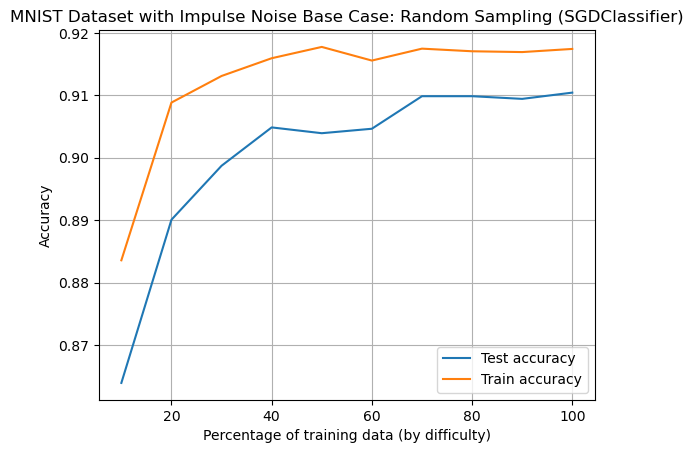

In [60]:
# Shuffle the training data with seed 42
X_shuffled, y_shuffled = shuffle(X_train_MNIST_IN, y_train_MNIST_IN, random_state=42)

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_IN)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_shuffled))
    X_curr = X_shuffled[:n_samples]
    y_curr = y_shuffled[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_IN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_IN, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("MNIST Dataset with Impulse Noise Base Case: Random Sampling (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (1) Curriculum Learning

#### Pre-analysis

In [61]:
def compute_MNIST_difficulty(X, y, centroids):
    dist = np.linalg.norm(X - centroids[y], axis=1)
    return dist

In [62]:
percentages = np.linspace(0.75, 1, 5)

#### Analysis

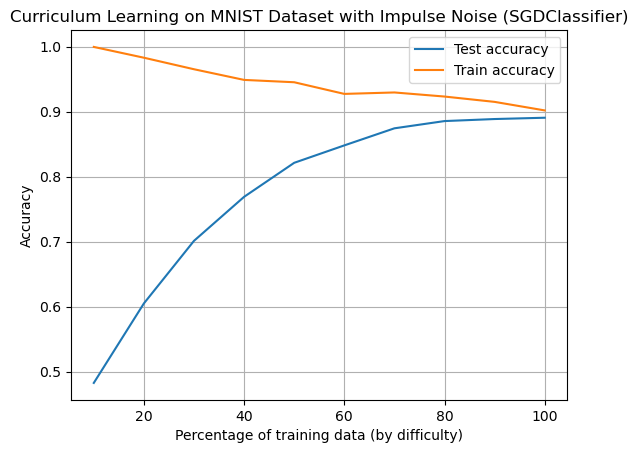

In [63]:
# compute class centroids to later apply the difficulty function
centroids = np.zeros((10, X_train_MNIST_IN.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST_IN[y_train_MNIST_IN == i].mean(axis=0)

# normalize the difficulty to [0, 1]
MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST_IN, y_train_MNIST_IN, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# sort by difficulty
sorted_indices = np.argsort(norm_MNIST_difficulty)
X_sorted = X_train_MNIST_IN[sorted_indices]
y_sorted = y_train_MNIST_IN[sorted_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_IN)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_sorted))
    X_curr = X_sorted[:n_samples]
    y_curr = y_sorted[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_IN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_IN, test_pred))

# Plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Curriculum Learning on MNIST Dataset with Impulse Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (2) Self-Paced Learning

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_37832/1791135984.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_37832/1791135984.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/va

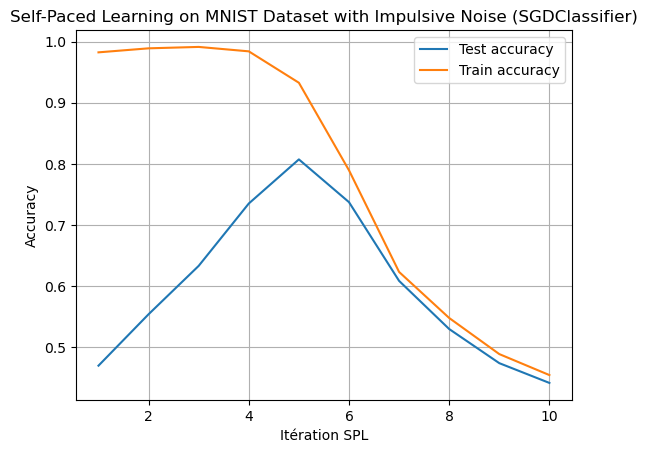

In [68]:
classes = np.unique(y_train_MNIST_IN)

# definition learning parameters
# lambda t : init threshold corresponding to the maximum loss (which then determines difficulty)
# lambda growth : incrementation at every step
# the model is then able to decide how many samples of such difficilty it can handle
max_iters = 10
lambda_t = 0.2
lambda_growth = 0.15

# init training on small random subset
init_size = 50
init_idx = np.random.choice(len(X_train_MNIST_IN), size=init_size, replace=False)
X_curr = X_train_MNIST_IN[init_idx]
y_curr = y_train_MNIST_IN[init_idx]

# remaining pool
mask = np.ones(len(X_train_MNIST_IN), dtype=bool)
mask[init_idx] = False
X_masked = X_train_MNIST_IN[mask]
y_masked = y_train_MNIST_IN[mask]

# initial fit
clf = SGDClassifier(loss="log_loss", random_state=42)
clf.partial_fit(X_curr, y_curr, classes=classes)

train_accuracies = []
test_accuracies = []

for it in range(1, max_iters + 1):
    # calculation probs & loss per sample
    probas = clf.predict_proba(X_masked)
    sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])

    filter_mask = sample_losses <= lambda_t
    if not np.any(filter_mask):
        break

    X_filtered = X_masked[filter_mask]
    y_filtered = y_masked[filter_mask]

    X_curr = np.vstack([X_curr, X_filtered])
    y_curr = np.concatenate([y_curr, y_filtered])

    X_masked = X_masked[~filter_mask]
    y_masked = y_masked[~filter_mask]

    clf.partial_fit(X_filtered, y_filtered)

    train_acc = accuracy_score(y_curr, clf.predict(X_curr))
    test_acc = accuracy_score(y_test_MNIST_IN, clf.predict(X_test_MNIST_IN))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    lambda_t += lambda_growth

# tracé des courbes d'apprentissage
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label="Test accuracy")
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train accuracy")
plt.xlabel("Itération SPL")
plt.ylabel("Accuracy")
plt.title("Self-Paced Learning on MNIST Dataset with Impulsive Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (3) Hard-Example Mining

/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

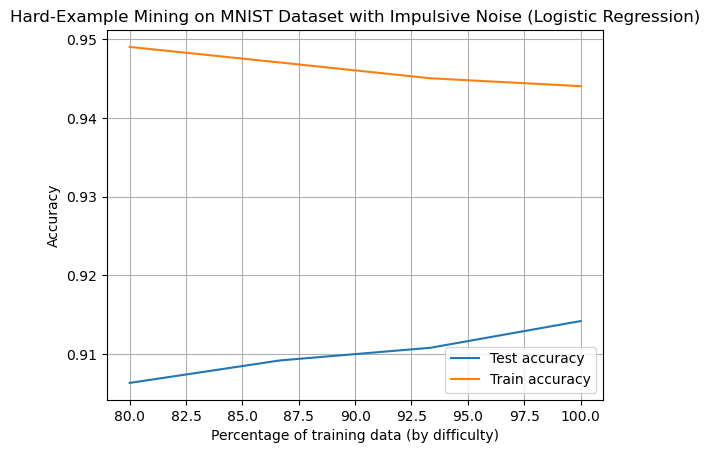

In [66]:
sorted_indices = np.argsort(norm_MNIST_difficulty)
X_sorted = X_MNIST_IN[sorted_indices]
y_sorted = y_MNIST_IN[sorted_indices]

# Curriculum training: increase % of training data
percentages = np.linspace(0.8, 1, 4)
train_accuracies = []
test_accuracies = []

# test set
X_train_all, X_test_MNIST_IN, y_train_all, y_test_MNIST_IN = train_test_split(X_sorted, y_sorted, test_size=0.2, random_state=42)

for percentage in percentages:
    n_samples = int(percentage * len(X_train_all))
    X_train_MNIST_IN = X_train_all[:n_samples]
    y_train_MNIST_IN = y_train_all[:n_samples]
    
    clf = LogisticRegression()
    clf.fit(X_train_MNIST_IN, y_train_MNIST_IN)
    
    train_acc = accuracy_score(y_train_MNIST_IN, clf.predict(X_train_MNIST_IN))
    test_acc = accuracy_score(y_test_MNIST_IN, clf.predict(X_test_MNIST_IN))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
# Plot
plt.plot(percentages * 100, test_accuracies, label="Test accuracy")
plt.plot(percentages * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Hard-Example Mining on MNIST Dataset with Impulsive Noise (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

### (4) Reverse Curriculum Learning

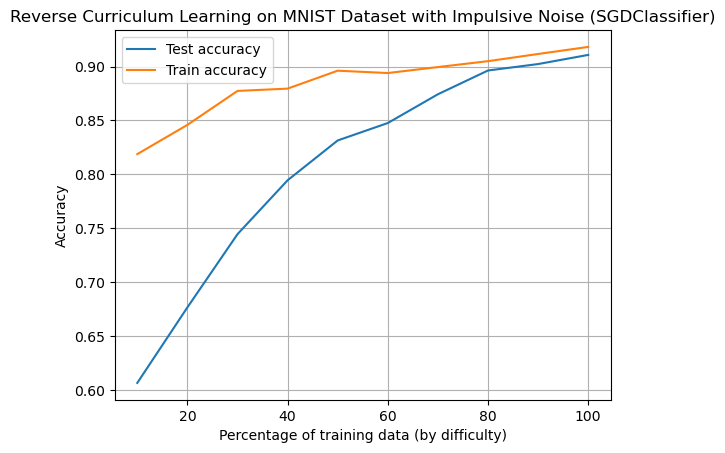

In [70]:
# compute class centroids to later apply the difficulty function
centroids = np.zeros((10, X_train_MNIST_IN.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST_IN[y_train_MNIST_IN == i].mean(axis=0)

# normalize the difficulty to [0, 1]
MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST_IN, y_train_MNIST_IN, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# sort by difficulty
sorted_indices = np.argsort(norm_MNIST_difficulty)[::-1] ## Reverse order for RCL
X_sorted = X_train_MNIST_IN[sorted_indices]
y_sorted = y_train_MNIST_IN[sorted_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_IN)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_sorted))
    X_curr = X_sorted[:n_samples]
    y_curr = y_sorted[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_IN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_IN, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Reverse Curriculum Learning on MNIST Dataset with Impulsive Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (5) Stratified Monte-Carlo Sampling

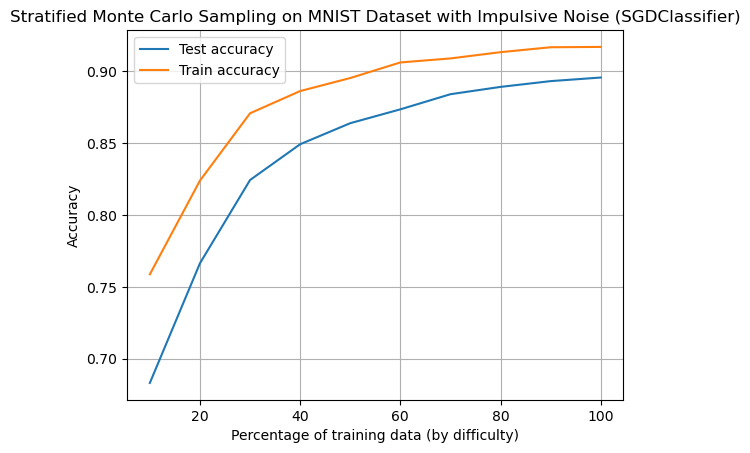

In [72]:
# compute difficulty and normalize it
centroids = np.zeros((10, X_train_MNIST_IN.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST_IN[y_train_MNIST_IN == i].mean(axis=0)

MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST_IN, y_train_MNIST_IN, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# stratify based on difficulty
n_strata = 10
strata_bounds = np.linspace(0, 1, n_strata + 1)
strata_indices = [np.where((norm_MNIST_difficulty >= strata_bounds[i]) & 
                           (norm_MNIST_difficulty < strata_bounds[i+1]))[0]
                  for i in range(n_strata)]

# training over growing percentages of the dataset
difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_IN)

for percentage in difficulty_range:
    n_total_samples = int(percentage * len(X_train_MNIST_IN))
    n_per_stratum = n_total_samples // n_strata

    selected_indices = []
    for indices in strata_indices:
        if len(indices) == 0:
            continue
        stratum_sample = np.random.choice(indices, min(n_per_stratum, len(indices)), replace=False)
        selected_indices.extend(stratum_sample)

    X_curr = X_train_MNIST_IN[selected_indices]
    y_curr = y_train_MNIST_IN[selected_indices]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_IN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_IN, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Stratified Monte Carlo Sampling on MNIST Dataset with Impulsive Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()